In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

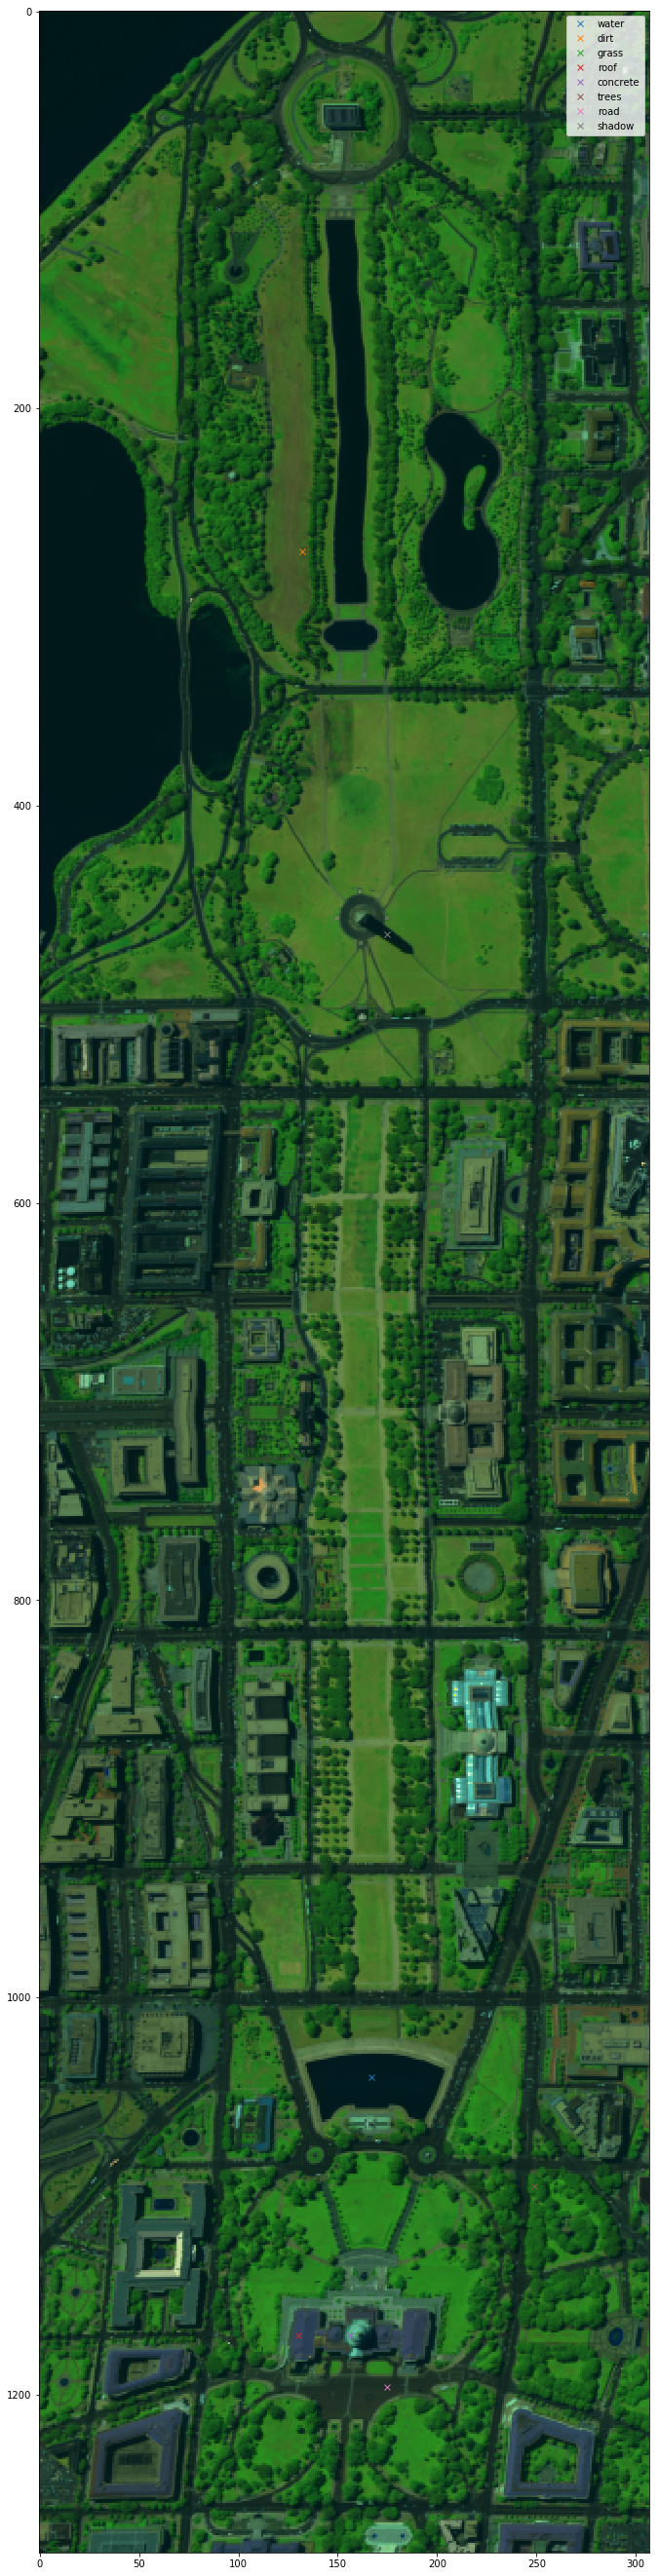

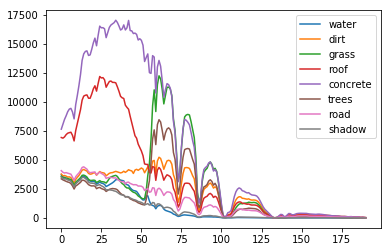

In [2]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])
points = dc.ref_points

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(12,48), show=False);

points = OrderedDict([
    ('water', (167, 1040)),
    ('dirt', (132, 272)),
    ('grass', (158, 1116)),
    #('grass', (166, 1105)),
    ('roof', (130, 1170)),
    ('concrete', (156, 1170)),
    #('trees', (249, 1123)),
    ('trees', (249, 1095)),
    ('road', (175, 1196)),
    #('road', (138, 1086)),
    ('shadow', (175, 465))
    #('shadow', (70, 1160))
])

spectra = OrderedDict()
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
plt.legend()
#plt.xlim([62,262])
#plt.ylim([1000,1200])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

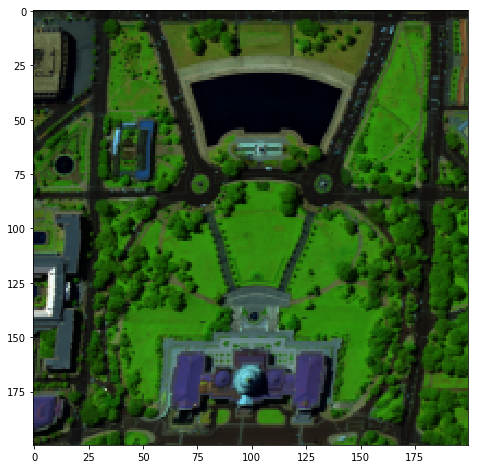

In [3]:
# only use a subset of the image
xmin = 62
xmax = 262
ymin = 1000
ymax = 1200
img_shape = (ymax-ymin, xmax-xmin)
subset = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
subset = subset.reshape(data.shape[0], img_shape[0]*img_shape[1])
dc.plot_color_img(subset, img_shape);

In [3]:
import scipy.special
import scipy.sparse

def prox_entropy(X, step):
    X = np.abs(scipy.special.lambertw(np.exp(X - 1)))# / step
    return X

points = dc.ref_points

A0,S0 = dc.init_nmf(data, img_shape, points)
Ls = [[None], [np.ones((1,S0.shape[0])), np.identity(S0.shape[0])]]

prox_A = proxmin.operators.prox_plus
prox_g = [[proxmin.operators.prox_id],[dc.prox_ones, prox_entropy]]

In [4]:
#A, S = nmf.nmf(data, A0, S0, prox_A, prox_S, max_iter=300)
#A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=300, l1_thresh=1000, Ls=Ls, proxs_g=prox_g)
#A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=1000, Ls=Ls, proxs_g=prox_g, l0_thresh=.1)
A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=100, Ls=Ls, proxs_g=prox_g, steps_g=[[None],[None, None]])
#A, S = nmf.nmf(data, A0, S0, prox_A, prox_entropy, max_iter=1000, Ls=Ls, proxs_g=prox_g)

1 1
2 2


INFO:proxmin.algorithms:Completed 101 iterations


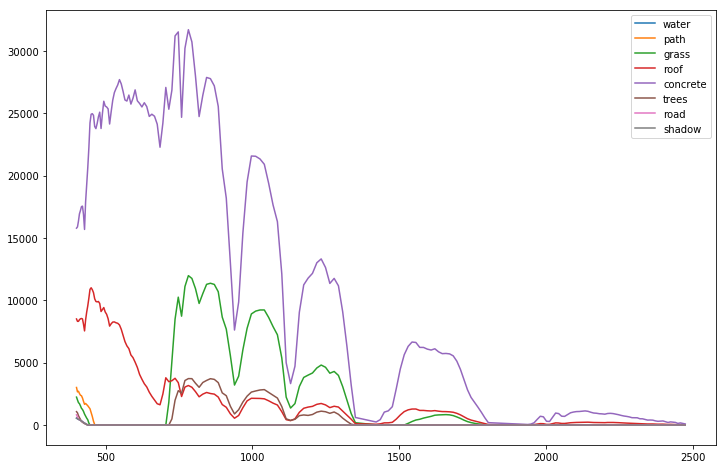

In [6]:
plt.figure(figsize=(12,8))
for row in range(A.shape[1]):
    plt.plot(wavelength, A[:,row], label=list(points.keys())[row])
    #plt.plot(A[:,row], label="Object {0}".format(row))
plt.legend()
plt.show()

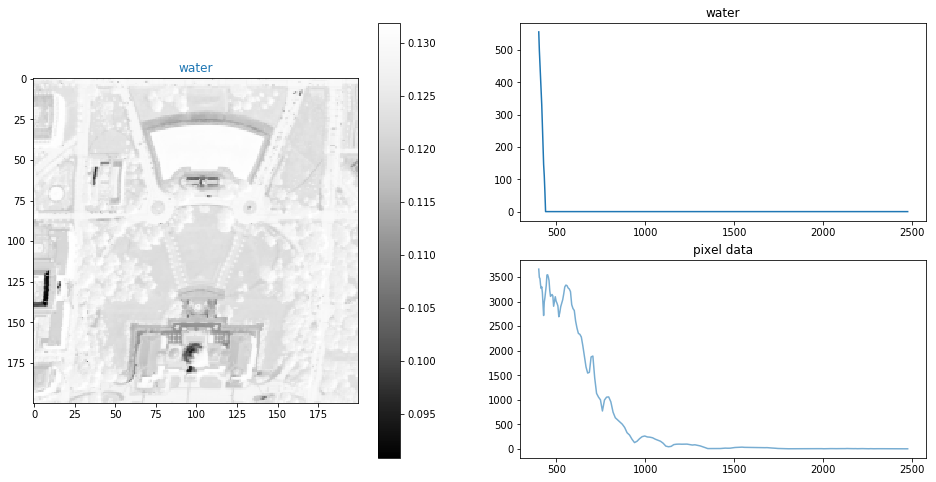

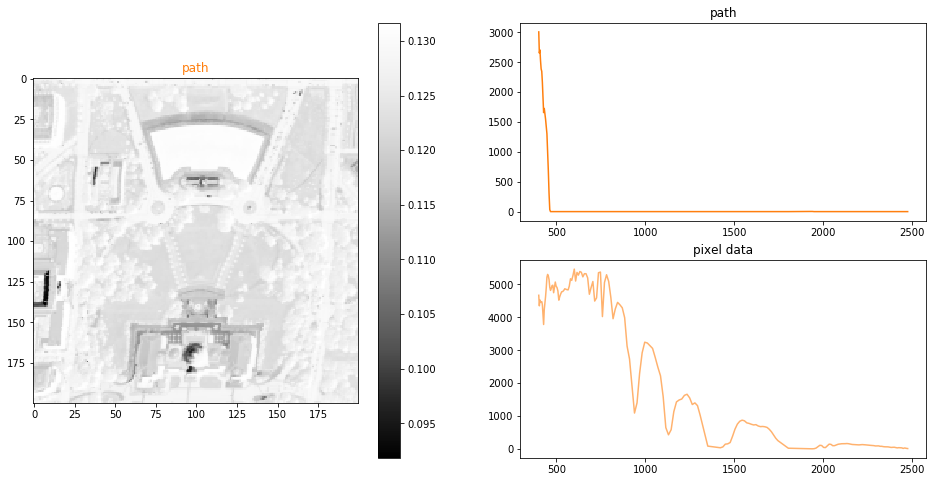

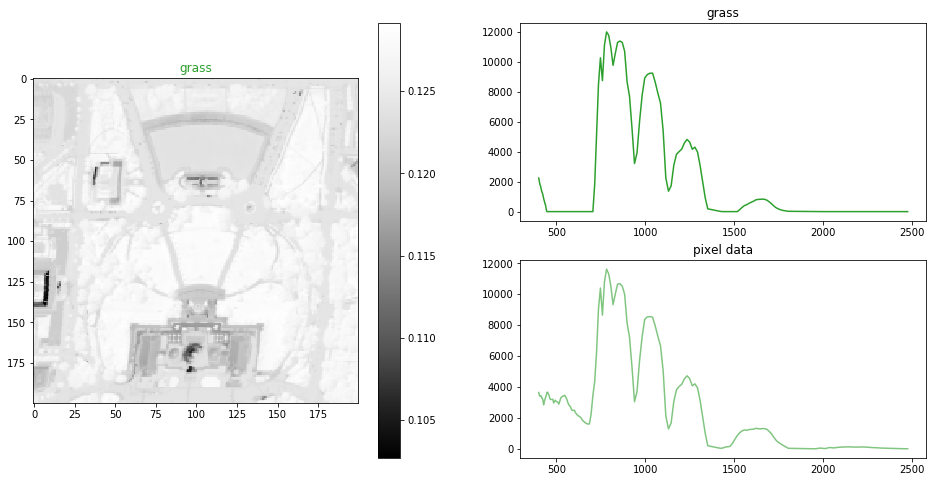

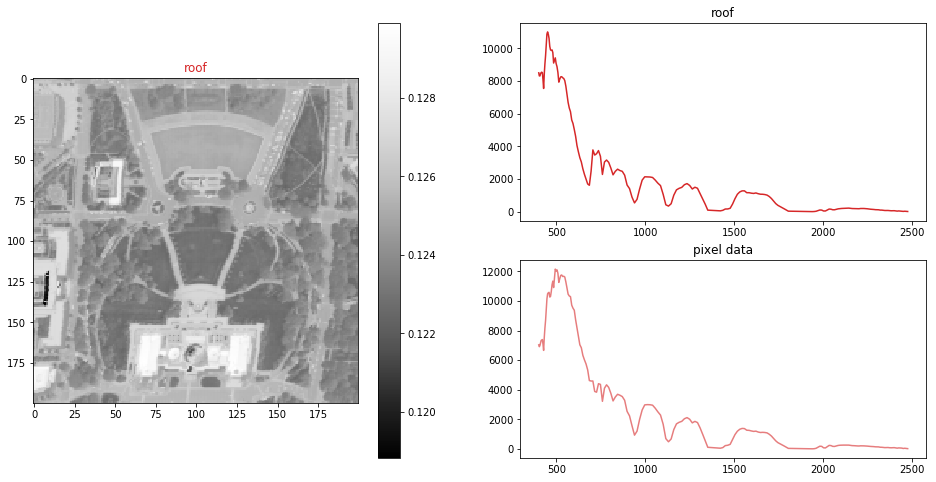

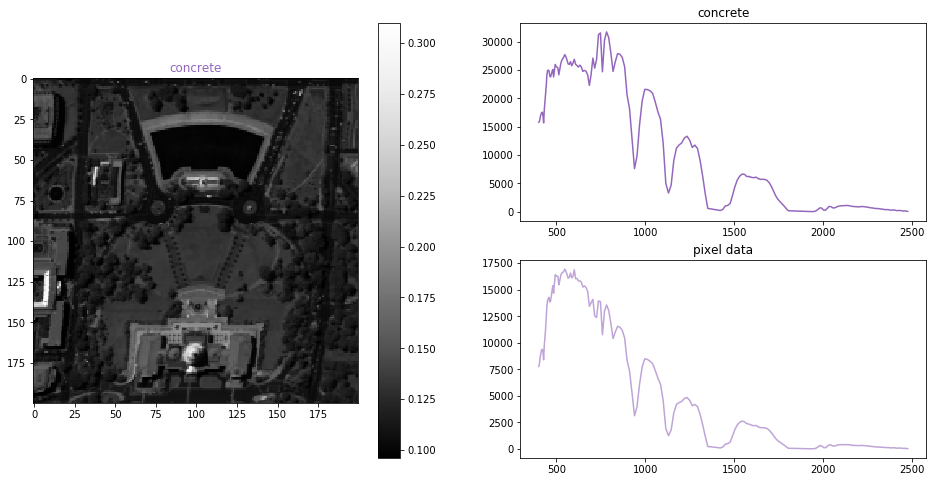

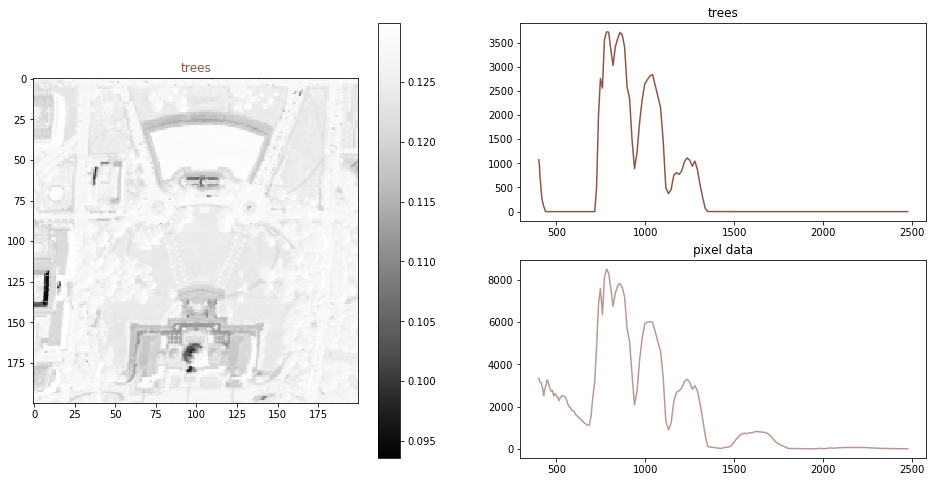

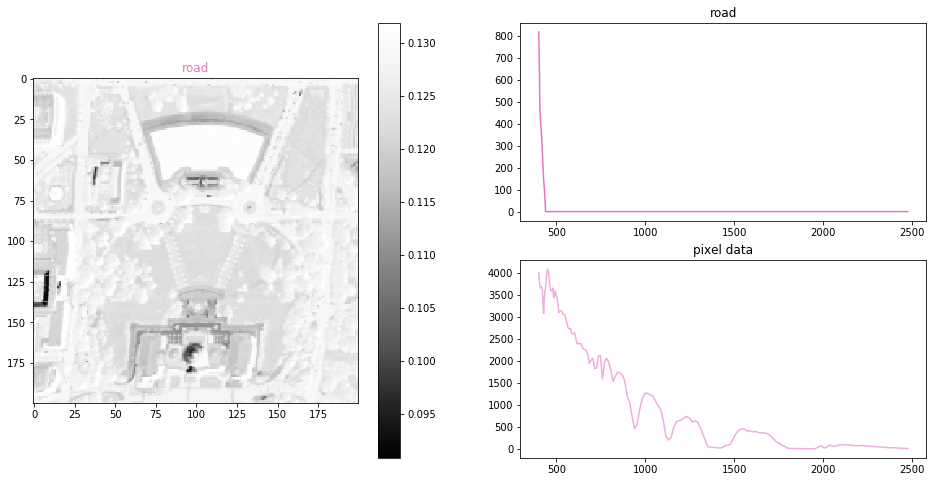

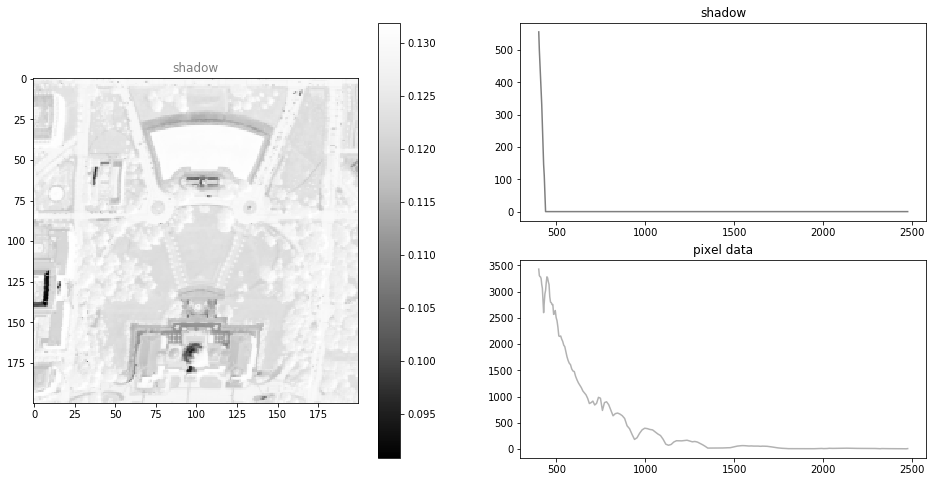

In [7]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, (obj,(x,y)) in enumerate(points.items()):
    spec = get_point_spec(x, y, data)
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title(obj, color=color_cycle[idx])
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,4)
    ax2.set_title(obj)
    img = S[idx].reshape(img_shape)
    img_plot = ax1.imshow(img, cmap="Greys_r")
    fig.colorbar(img_plot, ax=ax1)
    ax2.plot(wavelength, A[:,idx], color=color_cycle[idx])
    ax3.plot(wavelength, spec, color=color_cycle[idx], alpha=.6)
    ax3.set_title("pixel data")
    plt.show()